In [0]:
%tensorflow_version 1.x
import os
import re
import sys
import json
import pprint
import random
import string
import datetime
import warnings
import tensorflow as tf
from tensorflow import keras
warnings.filterwarnings('ignore')
tf.enable_eager_execution()

In [0]:
#TPU SET UP
assert 'COLAB_TPU_ADDR' in os.environ, 'NO TPU IS CONNECTED'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)
from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  #print('TPU devices:')
  #pprint.pprint(session.list_devices())
  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

AssertionError: ignored

In [0]:

from google.colab import auth
auth.authenticate_user()
with tf.Session() as session:
  #print('TPU devices:')
  #pprint.pprint(session.list_devices())
  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
#IMPORTING BERT PYTHON MODULES
import sys
!test -d bert_repo || git clone https://github.com/chandu7077/mybert.git bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

Cloning into 'bert_repo'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 36 (delta 12), reused 30 (delta 9), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [0]:
# import python modules defined by BERT
import modeling
import optimization
import run_classifier
import run_classifier_with_tfhub
import tokenization
# import tfhub for loading the model
import tensorflow_hub as hub

In [0]:
#SETTING OUTPUT DIRECTORY AND TFHUB FOR LOADING PRETRAINED MODEL
BUCKET = 'bertbase_final'
OUTPUT_DIR = 'gs://{}/{}'.format("olidtaskb",BUCKET)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('MODEL OUTPUT DIRECTORY : {0}'.format(OUTPUT_DIR))
# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
BERT_MODEL = 'cased_L-12_H-768_A-12' 
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_' + BERT_MODEL + '/1'

MODEL OUTPUT DIRECTORY : gs://olidtaskb/bertbase_final


In [0]:
#bert tokenizer
tokenizer = run_classifier_with_tfhub.create_tokenizer_from_hub_module(BERT_MODEL_HUB)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
!gsutil cp gs://olidtaska/task_a_distant.tsv train.tsv

Copying gs://olidtaska/task_a_distant.tsv...
- [1 files][  1.2 GiB/  1.2 GiB]   84.2 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [0]:
import pandas as pd
traint=pd.read_csv("train.tsv",sep="\t")
offdf=traint[traint.average>0.51]
offdf["label"]=0
notdf=traint[traint.average<0.5]
notdf["label"]=1
notdf=notdf.sample(len(offdf))
fulltrain=pd.concat([offdf,notdf])
fulltrain=fulltrain.sample(700000)

FileNotFoundError: ignored

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fulltrain, train_size = 0.5)
train.shape, test.shape

((350000, 5), (350000, 5))

In [0]:
train[train.label==1]

,id,text,average,std,label
4632479,1156316762285080576,@USER Hawkeye had a bow,0.165136,0.189946,1
407985,1160606782693101569,And what is wrong with referring to GCF in Tok...,0.298868,0.222644,1
4851889,1158592628809707525,@USER Was literally about to send this to you 😂,0.307679,0.246101,1
2820208,1161596856578826240,Lettuce and cucumbers ruin the Kota. Please do...,0.380284,0.094279,1
7885122,1186389186120687616,"@USER @USER I don't disagree, I'm just saying ...",0.234198,0.185946,1
...,...,...,...,...,...
4590444,1158325291095384066,"@USER @USER Man, I haven't seen you in awhile.",0.316796,0.300240,1
3564794,1162304750257229826,@USER We had so much fun running in circle tog...,0.238397,0.171877,1
499809,1161442304810475524,"@USER @USER @USER @USER Ah, I fell for the bai...",0.224512,0.131600,1
139200,1160789876595396608,"@USER @USER @USER Ps, the club didn’t act on i...",0.218473,0.182455,1


In [0]:
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()


def remove_noise(tweet):
    noises = ['URL', '@USER', '\'ve', 'n\'t', '\'s', '\'m']
    for noise in noises:
      tweet=str(tweet)
      tweet = tweet.replace(noise, '')
    return tweet

train.sentence=train.sentence.apply(lambda x:remove_noise(x))
test.sentence=test.sentence.apply(lambda x:remove_noise(x))

AttributeError: ignored

In [0]:
# Use the InputExample from bert run_classifier
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
label_list = [0,1]
train_examples = train.apply(lambda x: run_classifier.InputExample(guid=None, #unique ID for each text (optional)
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_examples = test.apply(lambda x: run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                  label = x[LABEL_COLUMN]), axis = 1)

In [0]:
train_examples[1011739].text_a

KeyError: ignored

In [0]:
train.mean(train.text,appl)

In [0]:
state=[]
def create_model(is_training, input_ids, input_mask, segment_ids, labels,
                 num_labels, bert_hub_module_handle):
  global state
  batch_size=8
  """Creates a classification model."""
  tags = set()
  if is_training:
    tags.add("train")
  bert_module = hub.Module(bert_hub_module_handle, tags=tags, trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  output_layer=bert_outputs["sequence_output"]
  
  output_weights = tf.get_variable(
      "output_weights", [num_labels,768 ],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())


  with tf.variable_scope("loss"):
    t1=output_layer[:,1:21]
    t2=output_layer[:,0]
    lstmcell =  tf.nn.rnn_cell.LSTMCell(768, state_is_tuple=True)
    outputs, states = tf.nn.dynamic_rnn(lstmcell,
                                  t1,
                                  sequence_length=[20]*t1.shape[0].value,
                                  dtype=tf.float32)
    
    output_layer=tf.reduce_mean([t2,states.h],0)
    state.append(states.h)
    if is_training:
      # I.e., 0.1 dropout
      output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)
    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    probabilities = tf.nn.sigmoid(logits)
    #log_probs = tf.nn.log_softmax(logits, axis=-1)

    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
    per_example_loss=tf.nn.weighted_cross_entropy_with_logits(
    labels=one_hot_labels,
    logits=logits,
    pos_weight=1,
    name=None,
    targets=None)
    #per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, per_example_loss, logits, probabilities)

In [0]:
#MODEL FUNCTION BUILDER
train_hook_list= []
def model_fn_builder(num_labels, learning_rate, num_train_steps,num_warmup_steps, use_tpu, bert_hub_module_handle):
  def model_fn(features, labels, mode, params):
    """The `model_fn` for TPUEstimator."""
    tf.logging.info("*** Features ***")
    for name in sorted(features.keys()):
      tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))
    # input ids which are obtained from bert tokenizer
    input_ids = features["input_ids"]
    # input masks to represent the actual sentence and padding sequence
    input_mask = features["input_mask"]
    # segment ids to distinguish in case of two sentence tasks (not needed for this task)
    segment_ids = features["segment_ids"]
    # label for sentence 
    label_ids = features["label_ids"]

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    (total_loss, per_example_loss, logits, probabilities) = create_model(
        is_training, input_ids, input_mask, segment_ids, label_ids, num_labels,
        bert_hub_module_handle)

    output_spec = None
    if mode == tf.estimator.ModeKeys.TRAIN:
      train_op = optimization.create_optimizer(
          total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)
      
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          train_op=train_op)
    elif mode == tf.estimator.ModeKeys.EVAL:

      def metric_fn(per_example_loss, label_ids, logits):
        predicted_labels = tf.argmax(logits, axis=-1, output_type=tf.int32)
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        loss = tf.metrics.mean(per_example_loss)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        out={
            "eval_accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }
        train_hook_list.append(tf.train.LoggingTensorHook(
                      tensors=out, every_n_iter=100))
        return {
            "eval_accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }
    
      eval_metrics = (metric_fn, [per_example_loss, label_ids, logits])
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          eval_metrics=eval_metrics)
    elif mode == tf.estimator.ModeKeys.PREDICT:
      if use_tpu:
        output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode, predictions={"probabilities": probabilities})
      else:
        output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions={"probabilities": probabilities},
                scaffold=None)
    else:
      raise ValueError(
          "Only TRAIN, EVAL and PREDICT modes are supported: %s" % (mode))

    return output_spec

  return model_fn

In [0]:
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
MAX_SEQ_LENGTH = 128
WARMUP_PROPORTION = 0.1
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500
num_train_steps = int(100000 / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
TPU_ADDRESS=None
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8
ITERATIONS_PER_LOOP = 1000

def get_run_config(output_dir):
  return tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=output_dir,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))
print("no of train steps:",num_train_steps)

ValueError: ignored

In [0]:
OUTPUT_DIR="gs://olid2020/basea2"
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=500,
    keep_checkpoint_max=1,
    save_checkpoints_steps=1000)

In [0]:
# Force TF Hub writes to the GS bucket we provide.
import os
os.environ['TFHUB_CACHE_DIR'] = OUTPUT_DIR

# Use the InputExample class from BERT's run_classifier code to create examples from the data
DATA_COLUMN = 'text'

LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0,1]
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=False,
  bert_hub_module_handle=BERT_MODEL_HUB
)
"""
estimator_from_tfhub = tf.contrib.tpu.TPUEstimator(
  use_tpu=False,
  model_fn=model_fn,
  config=run_config,
  #config=get_run_config(OUTPUT_DIR),
  train_batch_size=TRAIN_BATCH_SIZE,
  eval_batch_size=EVAL_BATCH_SIZE,
  predict_batch_size=PREDICT_BATCH_SIZE,
)
"""

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": 1})


INFO:tensorflow:Using config: {'_model_dir': 'gs://olid2020/basea2', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd62fbdeb00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'gs://olid2020/basea2', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd62fbdeb00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Train the model
history=None
#tokenizer = run_classifier_with_tfhub.create_tokenizer_from_hub_module(BERT_MODEL_HUB)
def model_train(estimator):
  train_features = run_classifier.convert_examples_to_features(
      train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('Started training at {}'.format(datetime.datetime.now()))
  train_input_fn = run_classifier.input_fn_builder(
      features=train_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=True,
      drop_remainder=True)
  history=estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
  print('Finished training at {}'.format(datetime.datetime.now()))

In [0]:
model_train(estimator_from_tfhub)

INFO:tensorflow:Writing example 0 of 350000


INFO:tensorflow:Writing example 0 of 350000


INFO:tensorflow:Writing example 10000 of 350000


INFO:tensorflow:Writing example 10000 of 350000


INFO:tensorflow:Writing example 20000 of 350000


INFO:tensorflow:Writing example 20000 of 350000


INFO:tensorflow:Writing example 30000 of 350000


INFO:tensorflow:Writing example 30000 of 350000


INFO:tensorflow:Writing example 40000 of 350000


INFO:tensorflow:Writing example 40000 of 350000


INFO:tensorflow:Writing example 50000 of 350000


INFO:tensorflow:Writing example 50000 of 350000


INFO:tensorflow:Writing example 60000 of 350000


INFO:tensorflow:Writing example 60000 of 350000


INFO:tensorflow:Writing example 70000 of 350000


INFO:tensorflow:Writing example 70000 of 350000


INFO:tensorflow:Writing example 80000 of 350000


INFO:tensorflow:Writing example 80000 of 350000


INFO:tensorflow:Writing example 90000 of 350000


INFO:tensorflow:Writing example 90000 of 350000


INFO:tensorflow:Writing example 100000 of 350000


INFO:tensorflow:Writing example 100000 of 350000


INFO:tensorflow:Writing example 110000 of 350000


INFO:tensorflow:Writing example 110000 of 350000


INFO:tensorflow:Writing example 120000 of 350000


INFO:tensorflow:Writing example 120000 of 350000


INFO:tensorflow:Writing example 130000 of 350000


INFO:tensorflow:Writing example 130000 of 350000


INFO:tensorflow:Writing example 140000 of 350000


INFO:tensorflow:Writing example 140000 of 350000


INFO:tensorflow:Writing example 150000 of 350000


INFO:tensorflow:Writing example 150000 of 350000


INFO:tensorflow:Writing example 160000 of 350000


INFO:tensorflow:Writing example 160000 of 350000


INFO:tensorflow:Writing example 170000 of 350000


INFO:tensorflow:Writing example 170000 of 350000


INFO:tensorflow:Writing example 180000 of 350000


INFO:tensorflow:Writing example 180000 of 350000


INFO:tensorflow:Writing example 190000 of 350000


INFO:tensorflow:Writing example 190000 of 350000


INFO:tensorflow:Writing example 200000 of 350000


INFO:tensorflow:Writing example 200000 of 350000


INFO:tensorflow:Writing example 210000 of 350000


INFO:tensorflow:Writing example 210000 of 350000


INFO:tensorflow:Writing example 220000 of 350000


INFO:tensorflow:Writing example 220000 of 350000


INFO:tensorflow:Writing example 230000 of 350000


INFO:tensorflow:Writing example 230000 of 350000


INFO:tensorflow:Writing example 240000 of 350000


INFO:tensorflow:Writing example 240000 of 350000


INFO:tensorflow:Writing example 250000 of 350000


INFO:tensorflow:Writing example 250000 of 350000


INFO:tensorflow:Writing example 260000 of 350000


INFO:tensorflow:Writing example 260000 of 350000


INFO:tensorflow:Writing example 270000 of 350000


INFO:tensorflow:Writing example 270000 of 350000


INFO:tensorflow:Writing example 280000 of 350000


INFO:tensorflow:Writing example 280000 of 350000


INFO:tensorflow:Writing example 290000 of 350000


INFO:tensorflow:Writing example 290000 of 350000


INFO:tensorflow:Writing example 300000 of 350000


INFO:tensorflow:Writing example 300000 of 350000


INFO:tensorflow:Writing example 310000 of 350000


INFO:tensorflow:Writing example 310000 of 350000


INFO:tensorflow:Writing example 320000 of 350000


INFO:tensorflow:Writing example 320000 of 350000


INFO:tensorflow:Writing example 330000 of 350000


INFO:tensorflow:Writing example 330000 of 350000


INFO:tensorflow:Writing example 340000 of 350000


INFO:tensorflow:Writing example 340000 of 350000


Started training at 2020-05-22 03:58:16.491768
INFO:tensorflow:Querying Tensorflow master (grpc://10.121.53.34:8470) for TPU system metadata.


INFO:tensorflow:Querying Tensorflow master (grpc://10.121.53.34:8470) for TPU system metadata.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2515633531048112650)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2515633531048112650)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3900855967440974192)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3900855967440974192)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2611862256532515247)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2611862256532515247)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2850615604283964336)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2850615604283964336)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 15822331449183245536)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 15822331449183245536)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 13203656899024254807)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 13203656899024254807)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 740907540828183046)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 740907540828183046)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 14879393891027502304)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 14879393891027502304)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 15476730980657790074)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 15476730980657790074)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 44740701558788593)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 44740701558788593)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16151803562553540026)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16151803562553540026)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (8, 128)


INFO:tensorflow:  name = input_ids, shape = (8, 128)


INFO:tensorflow:  name = input_mask, shape = (8, 128)


INFO:tensorflow:  name = input_mask, shape = (8, 128)


INFO:tensorflow:  name = label_ids, shape = (8,)


INFO:tensorflow:  name = label_ids, shape = (8,)


INFO:tensorflow:  name = segment_ids, shape = (8, 128)


INFO:tensorflow:  name = segment_ids, shape = (8, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Please use `layer.add_weight` method instead.


Instructions for updating:
Please use `layer.add_weight` method instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
targets is deprecated, use labels instead


Instructions for updating:
targets is deprecated, use labels instead


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into gs://olid2020/basea2/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into gs://olid2020/basea2/model.ckpt.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


INFO:tensorflow:Initialized dataset iterators in 21 seconds


INFO:tensorflow:Initialized dataset iterators in 21 seconds


INFO:tensorflow:Installing graceful shutdown hook.


INFO:tensorflow:Installing graceful shutdown hook.


INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR



INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR



INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 0 seconds


INFO:tensorflow:Initialized TPU in 0 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 949)


INFO:tensorflow:Outfeed finished for iteration (0, 949)


INFO:tensorflow:Saving checkpoints for 1000 into gs://olid2020/basea2/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into gs://olid2020/basea2/model.ckpt.


INFO:tensorflow:loss = 0.003504474, step = 1000


INFO:tensorflow:loss = 0.003504474, step = 1000


INFO:tensorflow:Enqueue next (562) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (562) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (562) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (562) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (1, 187)


INFO:tensorflow:Outfeed finished for iteration (1, 187)


INFO:tensorflow:loss = 0.596612, step = 1562 (41.238 sec)


INFO:tensorflow:loss = 0.596612, step = 1562 (41.238 sec)


INFO:tensorflow:global_step/sec: 13.6283


INFO:tensorflow:global_step/sec: 13.6283


INFO:tensorflow:examples/sec: 872.209


INFO:tensorflow:examples/sec: 872.209


INFO:tensorflow:Saving checkpoints for 1562 into gs://olid2020/basea2/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1562 into gs://olid2020/basea2/model.ckpt.


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Loss for final step: 0.596612.


INFO:tensorflow:Loss for final step: 0.596612.


INFO:tensorflow:training_loop marked as finished


INFO:tensorflow:training_loop marked as finished


Finished training at 2020-05-22 04:07:48.084730


In [0]:
def model_eval(estimator,test_examples):
  # Eval the model.
  eval_examples = test_examples
  eval_features = run_classifier.convert_examples_to_features(
      eval_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started evaluation at {} *****'.format(datetime.datetime.now()))
  # Eval will be slightly WRONG on the TPU because it will truncate
  # the last batch.
  eval_steps = int(len(eval_examples) / EVAL_BATCH_SIZE)
  eval_input_fn = run_classifier.input_fn_builder(
      features=eval_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=False,
      drop_remainder=True)
  result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
  print('***** Finished evaluation at {} *****'.format(datetime.datetime.now()))
  output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
  with tf.gfile.GFile(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
      print('  {} = {}'.format(key, str(result[key])))
      writer.write("%s = %s\n" % (key, str(result[key])))

In [0]:
model_eval(estimator_from_tfhub,test_examples)

INFO:tensorflow:Writing example 0 of 350000


INFO:tensorflow:Writing example 0 of 350000


INFO:tensorflow:Writing example 10000 of 350000


INFO:tensorflow:Writing example 10000 of 350000


INFO:tensorflow:Writing example 20000 of 350000


INFO:tensorflow:Writing example 20000 of 350000


INFO:tensorflow:Writing example 30000 of 350000


INFO:tensorflow:Writing example 30000 of 350000


INFO:tensorflow:Writing example 40000 of 350000


INFO:tensorflow:Writing example 40000 of 350000


INFO:tensorflow:Writing example 50000 of 350000


INFO:tensorflow:Writing example 50000 of 350000


INFO:tensorflow:Writing example 60000 of 350000


INFO:tensorflow:Writing example 60000 of 350000


INFO:tensorflow:Writing example 70000 of 350000


INFO:tensorflow:Writing example 70000 of 350000


INFO:tensorflow:Writing example 80000 of 350000


INFO:tensorflow:Writing example 80000 of 350000


INFO:tensorflow:Writing example 90000 of 350000


INFO:tensorflow:Writing example 90000 of 350000


INFO:tensorflow:Writing example 100000 of 350000


INFO:tensorflow:Writing example 100000 of 350000


INFO:tensorflow:Writing example 110000 of 350000


INFO:tensorflow:Writing example 110000 of 350000


INFO:tensorflow:Writing example 120000 of 350000


INFO:tensorflow:Writing example 120000 of 350000


INFO:tensorflow:Writing example 130000 of 350000


INFO:tensorflow:Writing example 130000 of 350000


INFO:tensorflow:Writing example 140000 of 350000


INFO:tensorflow:Writing example 140000 of 350000


INFO:tensorflow:Writing example 150000 of 350000


INFO:tensorflow:Writing example 150000 of 350000


INFO:tensorflow:Writing example 160000 of 350000


INFO:tensorflow:Writing example 160000 of 350000


INFO:tensorflow:Writing example 170000 of 350000


INFO:tensorflow:Writing example 170000 of 350000


INFO:tensorflow:Writing example 180000 of 350000


INFO:tensorflow:Writing example 180000 of 350000


INFO:tensorflow:Writing example 190000 of 350000


INFO:tensorflow:Writing example 190000 of 350000


INFO:tensorflow:Writing example 200000 of 350000


INFO:tensorflow:Writing example 200000 of 350000


INFO:tensorflow:Writing example 210000 of 350000


INFO:tensorflow:Writing example 210000 of 350000


INFO:tensorflow:Writing example 220000 of 350000


INFO:tensorflow:Writing example 220000 of 350000


INFO:tensorflow:Writing example 230000 of 350000


INFO:tensorflow:Writing example 230000 of 350000


INFO:tensorflow:Writing example 240000 of 350000


INFO:tensorflow:Writing example 240000 of 350000


INFO:tensorflow:Writing example 250000 of 350000


INFO:tensorflow:Writing example 250000 of 350000


INFO:tensorflow:Writing example 260000 of 350000


INFO:tensorflow:Writing example 260000 of 350000


INFO:tensorflow:Writing example 270000 of 350000


INFO:tensorflow:Writing example 270000 of 350000


INFO:tensorflow:Writing example 280000 of 350000


INFO:tensorflow:Writing example 280000 of 350000


INFO:tensorflow:Writing example 290000 of 350000


INFO:tensorflow:Writing example 290000 of 350000


INFO:tensorflow:Writing example 300000 of 350000


INFO:tensorflow:Writing example 300000 of 350000


INFO:tensorflow:Writing example 310000 of 350000


INFO:tensorflow:Writing example 310000 of 350000


INFO:tensorflow:Writing example 320000 of 350000


INFO:tensorflow:Writing example 320000 of 350000


INFO:tensorflow:Writing example 330000 of 350000


INFO:tensorflow:Writing example 330000 of 350000


INFO:tensorflow:Writing example 340000 of 350000


INFO:tensorflow:Writing example 340000 of 350000


***** Started evaluation at 2020-05-22 04:09:28.889616 *****
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-22T04:11:23Z


INFO:tensorflow:Starting evaluation at 2020-05-22T04:11:23Z


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://olid2020/basea2/model.ckpt-1562


INFO:tensorflow:Restoring parameters from gs://olid2020/basea2/model.ckpt-1562


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 0 seconds


INFO:tensorflow:Initialized TPU in 0 seconds


INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 21 seconds


INFO:tensorflow:Initialized dataset iterators in 21 seconds


INFO:tensorflow:Enqueue next (43750) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (43750) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (43750) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (43750) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 16823)


INFO:tensorflow:Outfeed finished for iteration (0, 16823)


INFO:tensorflow:Outfeed finished for iteration (0, 35890)


INFO:tensorflow:Outfeed finished for iteration (0, 35890)


INFO:tensorflow:Evaluation [43750/43750]


INFO:tensorflow:Evaluation [43750/43750]


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Finished evaluation at 2020-05-22-04:14:53


INFO:tensorflow:Finished evaluation at 2020-05-22-04:14:53


INFO:tensorflow:Saving dict for global step 1562: eval_accuracy = 0.9591171, false_negatives = 9908.0, false_positives = 4401.0, global_step = 1562, loss = 0.15441038, precision = 0.9740276, recall = 0.9433686, true_negatives = 170643.0, true_positives = 165048.0


INFO:tensorflow:Saving dict for global step 1562: eval_accuracy = 0.9591171, false_negatives = 9908.0, false_positives = 4401.0, global_step = 1562, loss = 0.15441038, precision = 0.9740276, recall = 0.9433686, true_negatives = 170643.0, true_positives = 165048.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1562: gs://olid2020/basea2/model.ckpt-1562


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1562: gs://olid2020/basea2/model.ckpt-1562


INFO:tensorflow:evaluation_loop marked as finished


INFO:tensorflow:evaluation_loop marked as finished


***** Finished evaluation at 2020-05-22 04:15:23.011051 *****
***** Eval results *****
  eval_accuracy = 0.9591171
  false_negatives = 9908.0
  false_positives = 4401.0
  global_step = 1562
  loss = 0.15441038
  precision = 0.9740276
  recall = 0.9433686
  true_negatives = 170643.0
  true_positives = 165048.0


In [0]:
!wget https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv

--2020-05-22 08:30:41--  https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546446 (2.4M) [text/plain]
Saving to: ‘labeled_data.csv’

labeled_data.csv    100%[===================>]   2.43M  --.-KB/s    in 0.09s   

2020-05-22 08:30:41 (25.6 MB/s) - ‘labeled_data.csv’ saved [2546446/2546446]



In [0]:
test=pd.read_csv("labeled_data.csv")
test=test[test["class"]<=1]
test 

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
...,...,...,...,...,...,...,...
24776,25289,3,3,0,0,0,you're all niggers
24777,25290,3,2,1,0,0,you're such a retard i hope you get type 2 dia...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...


In [0]:
import pandas as pd
testt=pd.read_csv("olidtesta.tsv",sep="\t")
test_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in test["tweet"]]
eval_examples = test_examples
eval_features = run_classifier.convert_examples_to_features(
      eval_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
print('***** Started evaluation at {} *****'.format(datetime.datetime.now()))
predict_input_fn = run_classifier.input_fn_builder(features=eval_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=True)
predictions = estimator.predict(predict_input_fn)

INFO:tensorflow:Writing example 0 of 20620


INFO:tensorflow:Writing example 0 of 20620


INFO:tensorflow:Writing example 10000 of 20620


INFO:tensorflow:Writing example 10000 of 20620


INFO:tensorflow:Writing example 20000 of 20620


INFO:tensorflow:Writing example 20000 of 20620


***** Started evaluation at 2020-05-22 08:47:02.500587 *****


<BarContainer object of 17 artists>

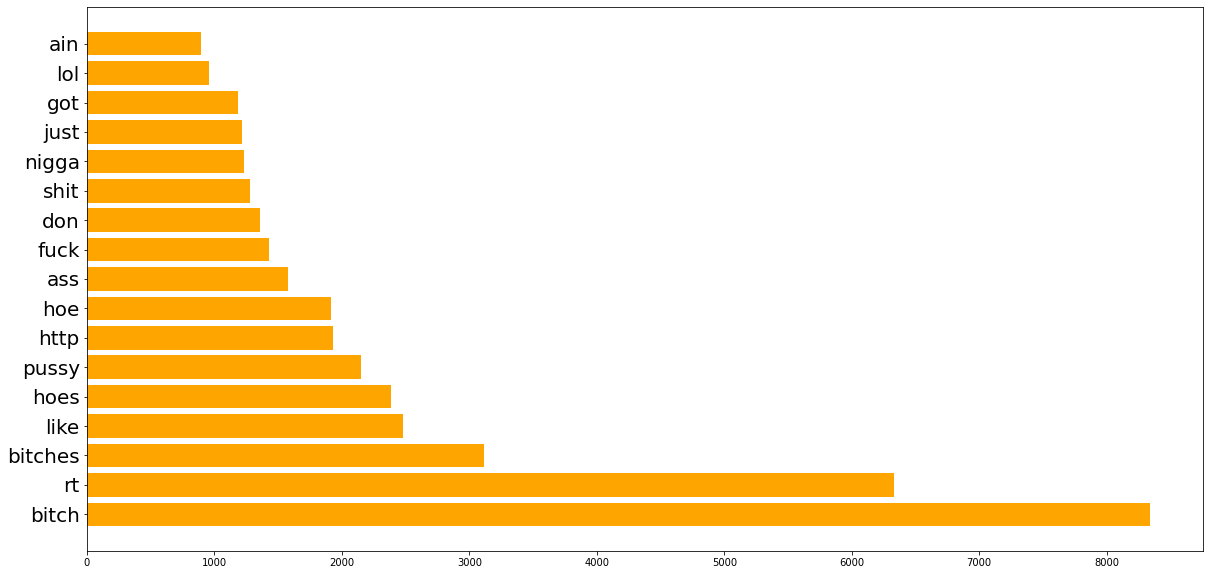

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(test['tweet'], 20)
words=[]
freqs=[]
for word, freq in common_words:
    if word not in ["128514","8220","8221"]:
      words.append(word)
      freqs.append(freq)
plt.figure(figsize=(20,10)) 
plt.yticks(size=20)
plt.barh(words,freqs,color="orange",)

In [0]:
ans5=[]
for it in predictions:
  ans5.append(it)

In [0]:
import numpy as np
pred=[]
probs=[]
for s,v in zip(testt["tweet"],ans5):
  pro=v["probabilities"]
  k=np.argmax(pro)
  pred.append(k)
  probs.append(pro[1])

In [0]:
from sklearn.metrics import accuracy_score
truel=list(testt.label)
accuracy_score(pred,truel)

ValueError: ignored

In [0]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(truel,pred)
cm

array([[173,  67],
       [ 72, 548]])

Logistic: f1=0.958 auc=0.993


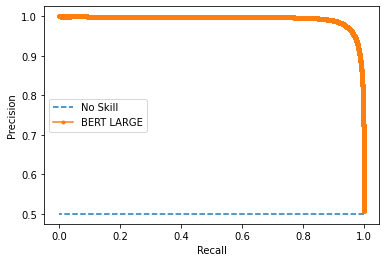

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

# predict probabilities
lr_probs = probs
# keep probabilities for the positive outcome only
# predict class values
lr_precision, lr_recall, _ = precision_recall_curve(truel, lr_probs)
lr_f1, lr_auc = f1_score(truel, pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
c=0
for i in truel:
  if i==0:
    c+=1
no_skill = c / len(truel)
pyplot.plot([1, 0], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='BERT LARGE')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()

In [0]:
from sklearn.metrics import classification_report
print(classification_report(truel,pred,target_names=["TIN","UNT"]))

              precision    recall  f1-score   support

         TIN       0.95      0.97      0.96    175044
         UNT       0.97      0.94      0.96    174956

    accuracy                           0.96    350000
   macro avg       0.96      0.96      0.96    350000
weighted avg       0.96      0.96      0.96    350000



In [0]:
from sklearn.metrics import classification_report
print(classification_report(truel,pred,target_names=["IND","GRP","OTH"]))

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(truel,pred,)

In [0]:
train

,id,text,average,std,label
4632479,1156316762285080576,@USER Hawkeye had a bow,0.165136,0.189946,1
7845126,1188689598399930368,“I’ll stay talking shit till the day someone b...,0.854573,0.162885,0
407985,1160606782693101569,And what is wrong with referring to GCF in Tok...,0.298868,0.222644,1
4851889,1158592628809707525,@USER Was literally about to send this to you 😂,0.307679,0.246101,1
1641634,1162033401853087746,next year i’m going to thailand or some shit a...,0.839686,0.150487,0
...,...,...,...,...,...
499809,1161442304810475524,"@USER @USER @USER @USER Ah, I fell for the bai...",0.224512,0.131600,1
139200,1160789876595396608,"@USER @USER @USER Ps, the club didn’t act on i...",0.218473,0.182455,1
8713047,1186118617580093442,@USER I see you don’t want me to be a fan anym...,0.607242,0.106090,0
4611501,1158368324318900224,@USER this seems a little angry? did you appl...,0.357814,0.177934,1


In [0]:
test

,id,text,average,std,label
4014953,1157538642430058496,To steal someone’s wig and wear it freely afte...,0.446529,0.205266,1
3754035,1162485298590375936,@USER Alright! Do you want me to DM you on Dis...,0.217854,0.172288,1
7214571,1187864398720917504,Ranking #StarWars Empire New Hope Revenge of ...,0.275036,0.177671,1
8987834,1187481168909918209,If I'm annoying say it to my fucken face,0.673865,0.274566,0
7192834,1186995062519021568,"Begged this mf to make collard greens for me, ...",0.625509,0.209046,0
...,...,...,...,...,...
6574065,1188132322035617792,@USER @USER Do we have any chance to see hit i...,0.182339,0.181068,1
5693833,1155933443055747073,these folks and they bad ass energy 😒,0.865989,0.155679,0
3106915,1162116992851206144,@USER fuck you ate it whole?,0.881532,0.136029,0
6953429,1186081823626911744,@USER Come over here too Playa Vista and try d...,0.219700,0.193037,1


In [0]:
tf.reduce_mean(ten[:,1:3],1)

In [0]:
for i in range(0,2):
  t1=tf.reduce_mean(ten[i][1:3],0,keep_dims=True)
  t2=tf.reshape(ten[i][0],(1,3))
  t1=tf.concat([t2,t1],1)
  out.append(t1)
tf.convert_to_tensor(out)

In [0]:
tf.concat([t1,t2],1)

In [0]:
t1=tf.reduce_mean(ten[:,1:3],1)
t2=ten[:,0]
t3=tf.concat([t1,t2],1)
print(t3)